# Re-tuning the flume before taking "high" flow measurmenets

Before I took measurements of "high" flow conditions (The same pump power as "low" but without that many grids put into the flume) the pump died. 
I had to re-tune the flow to achieve similar flows with a new pump which we bought in the summer.
Re-tuning meant that I used 5 points in the experimental arena to get values of flow as close as possible to the ones measured in Spring.
It was the same model and all the inflows were the same, however we expected difference in the power just on account of engine wear and tear in the old pump.
The following shows that the difference of stable flow in 7 points in the experimental arena (14 measurements as there are two direction of flow), 
is not significantly diffrent than zero

'data.frame':	14 obs. of  3 variables:
 $ mar.low: num  17 16 6 13 11 15 14 8.5 11 8 ...
 $ oct.low: num  15.7 14.3 4.3 11.9 11.9 ...
 $ diff   : num  1.3 1.7 1.7 1.05 -0.889 ...



Call:
glm(formula = diff ~ 1, family = "gaussian", data = flowtune)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4044  -1.3502   0.0651   1.1290   6.1790  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.5710     0.6829   0.836    0.418

(Dispersion parameter for gaussian family taken to be 6.52974)

    Null deviance: 84.887  on 13  degrees of freedom
Residual deviance: 84.887  on 13  degrees of freedom
AIC: 68.962

Number of Fisher Scoring iterations: 2


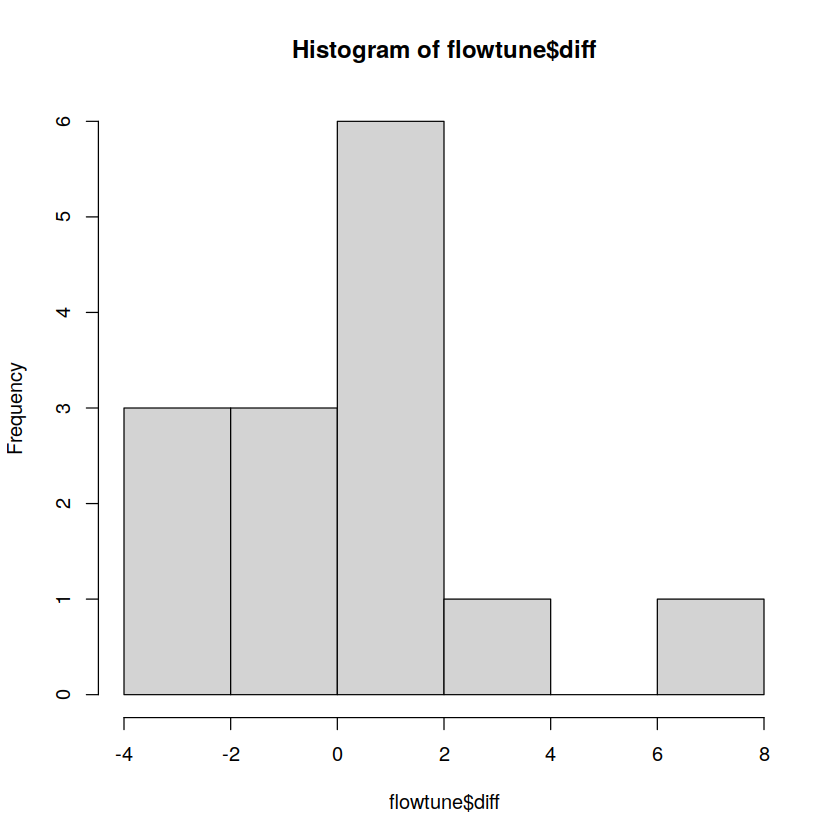

In [1]:
flowtune <- read.csv('./input/flowtune.csv')
str(flowtune)
hist(flowtune$diff)
modeltuneflow <- glm(diff ~ 1,flowtune,family='gaussian')
summary(modeltuneflow)

# Modelling of the data

In [2]:
fishes <- read.csv("input/finresoct.csv")
str(fishes)
fishes <- subset(fishes, info != 'error')
## now trying to plot histogram of outcomes...
unique(fishes$info)
#
#boxplot(table(fishes$info))
#library(ggplot2)
#ggp <- ggplot(data.frame(fishes$info),aes(x=fishes$info))
#ggp + geom_histogram(fill="lightgreen")
#ggp + geom_histogram(fill="lightblue",aes(y=..count../sum(..count..)))


'data.frame':	141 obs. of  36 variables:
 $ fishname      : chr  "fish58" "fish59" "fish60" "fish64" ...
 $ fs            : chr  "low" "low" "low" "low" ...
 $ fishdate      : chr  "13Mar" "13Mar" "13Mar" "13Mar" ...
 $ time_flow     : chr  "15:17:32" "15:45:57" "16:13:24" "18:07:33" ...
 $ time_react    : chr  "-" "-" "-" "-" ...
 $ tdiff         : chr  "nan" "nan" "nan" "nan" ...
 $ info          : chr  "unstable" "unstable" "unstable" "unstable" ...
 $ info_other    : chr  "" "" "" "" ...
 $ direction     : chr  "counter" "clock" "counter" "counter" ...
 $ stable10prev  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ change10      : num  NA NA NA NA NA NA NA NA NA NA ...
 $ stable10after : num  NA NA NA NA NA NA NA NA NA NA ...
 $ fishtype      : chr  "farmed_loch" "farmed_loch" "farmed_loch" "farmed_loch" ...
 $ loc_name      : chr  "" "" "" "" ...
 $ loc_x         : num  NA NA NA NA NA NA NA NA NA NA ...
 $ loc_y         : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Unnamed..3    : logi

[1] "unstable"    "no_reaction" "dir_change"  "swim_off"

# Question 1: What is the behaviour response of salmon smolts to switching current?

I'm not sure what should we look at here. As you can see we are defining a success as dir_change, no_reaction as a failure and if fish is unstable or swims off, it is ambivalent (dk == don't known). 

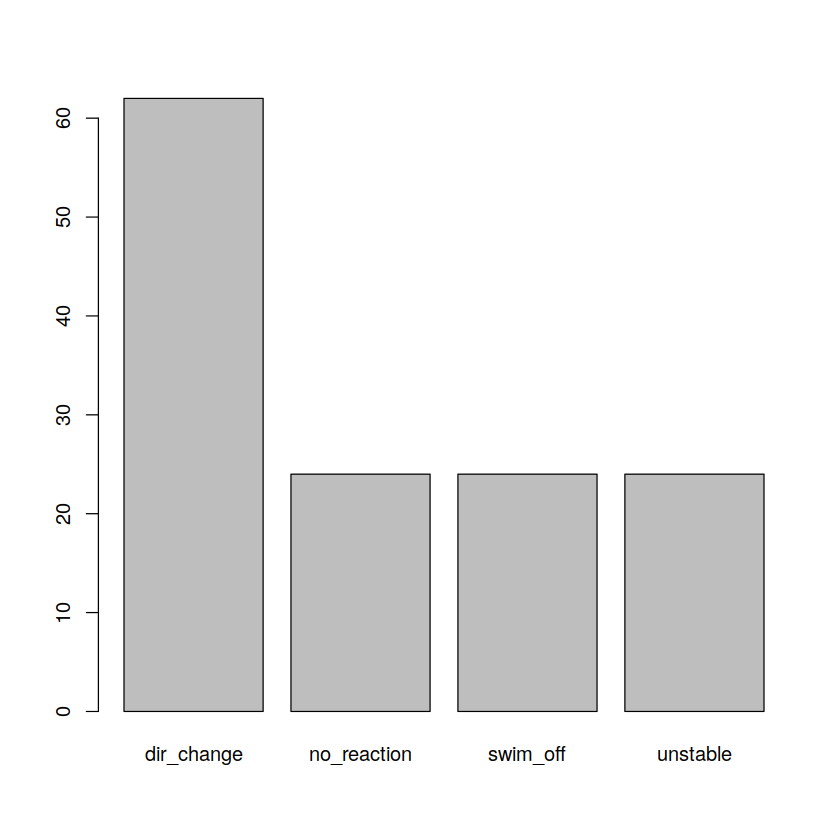

In [3]:
plot(factor(fishes$info))

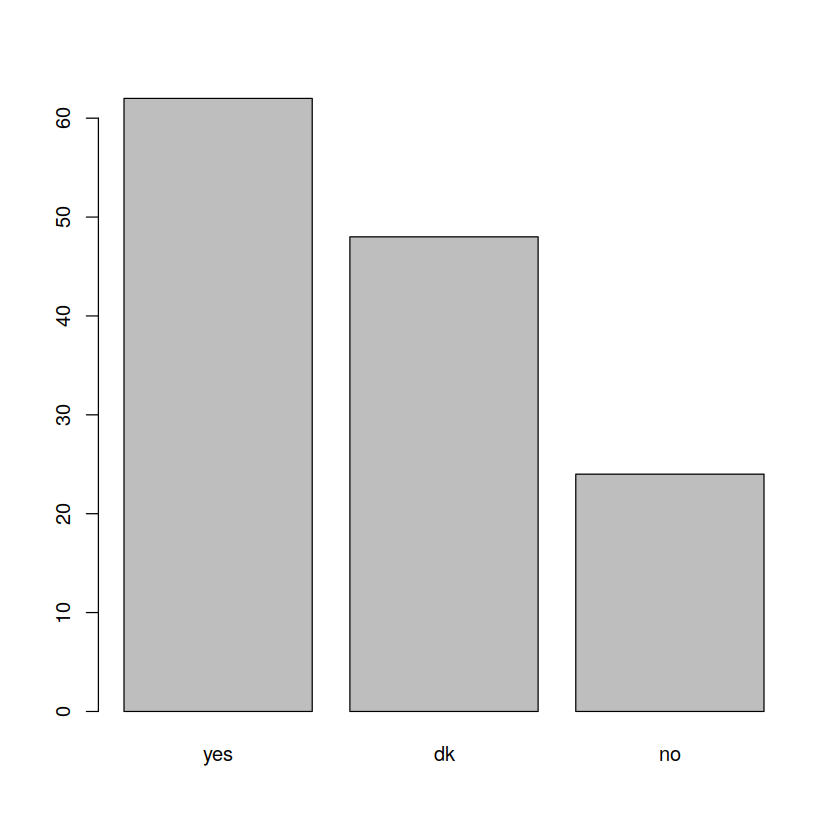

In [4]:
fishes$success <- relevel(factor(fishes$success), "yes")
plot(factor(fishes$success))


In [5]:
fishesknown <- subset(fishes, success != 'dk')

modelreacted <- glm(factor(fishesknown$success) ~ 1,family='binomial')
summary(modelreacted)


Call:
glm(formula = factor(fishesknown$success) ~ 1, family = "binomial")

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.809  -0.809  -0.809   1.598   1.598  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.9491     0.2404  -3.948 7.89e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 101.84  on 85  degrees of freedom
Residual deviance: 101.84  on 85  degrees of freedom
AIC: 103.84

Number of Fisher Scoring iterations: 4


# Question 2: Does the response differ between fish types and flow conditions?

no

In [6]:
modelreacted2 <- glm(success ~ fishtype + fsdir + fishtype*fsdir,fishes,family='binomial')
summary(modelreacted2)


Call:
glm(formula = success ~ fishtype + fsdir + fishtype * fsdir, 
    family = "binomial", data = fishes)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4490  -1.1774   0.9282   1.0302   1.3537  

Coefficients: (10 not defined because of singularities)
                                      Estimate Std. Error z value Pr(>|z|)  
(Intercept)                             0.6190     0.4688   1.320   0.1867  
fishtypefarmed_loch                    -0.2624     0.6802  -0.386   0.6997  
fishtypewild                           -0.6190     0.6854  -0.903   0.3664  
fsdirhigh_counter                       0.1335     0.7196   0.186   0.8528  
fsdirlow_clock                          0.1133     0.7536   0.150   0.8805  
fsdirlow_counter                        0.1133     0.7536   0.150   0.8805  
fsdirold_clock                         -1.0245     0.6216  -1.648   0.0993 .
fsdirold_counter                            NA         NA      NA       NA  
fishtypefarmed_loch:fsdirhi

# Question 3: Does fish type or flow conditions affect the flow rate at which fish turns (or time at wchich, or fraction of holding flow)

In [7]:
fs <- subset(fishes, success == 'yes') #looking only at sucessful fish, our superstars

## Time as an explanatory variable

It seems that fish was switching marginally faster in case of wild smolts

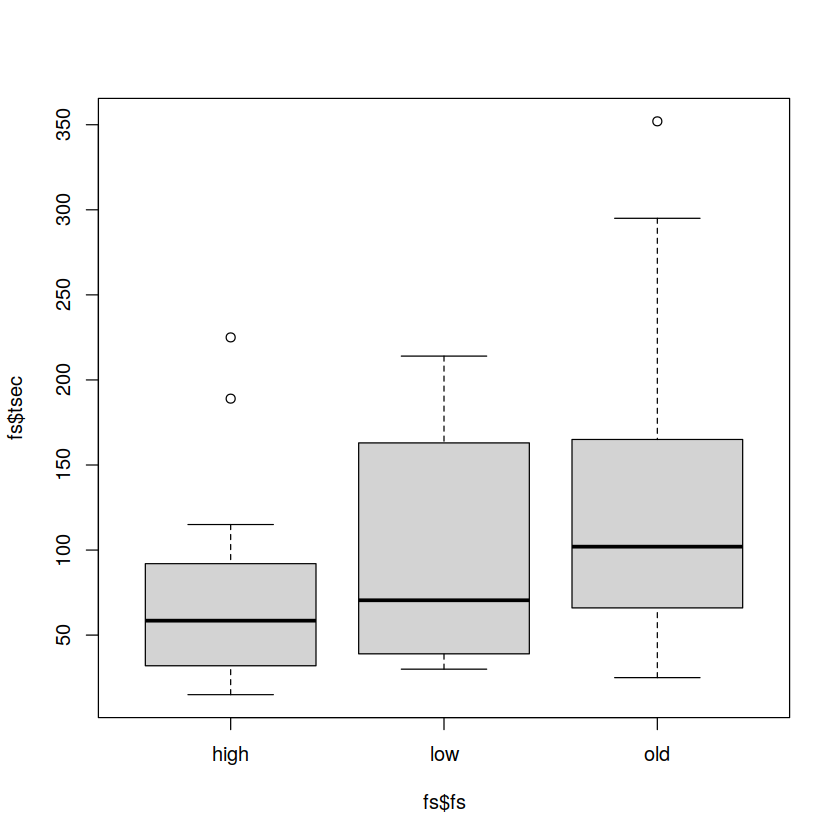

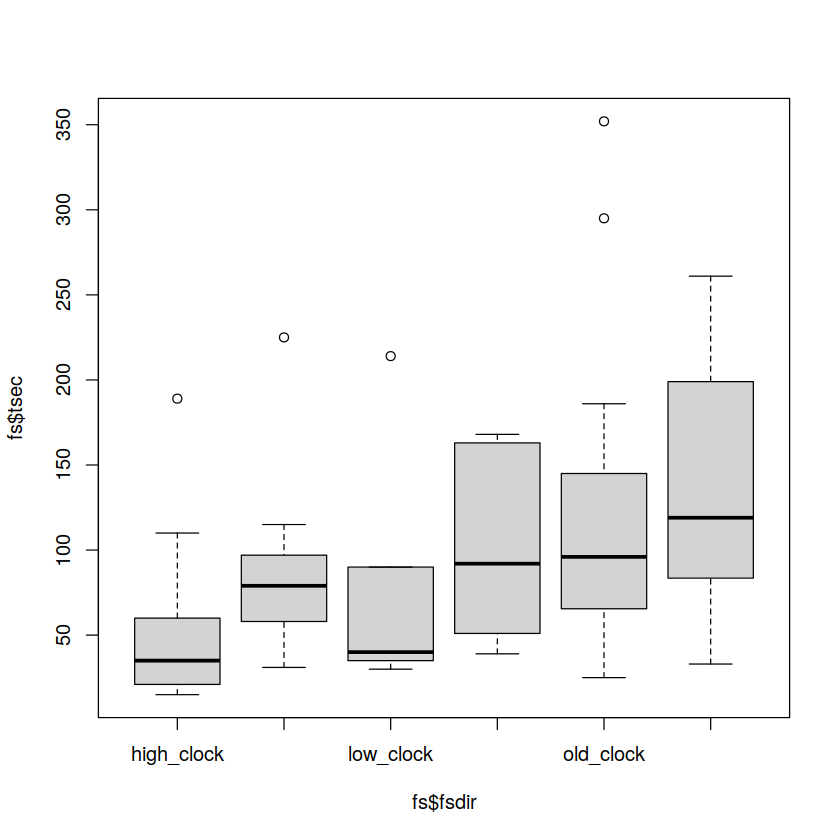

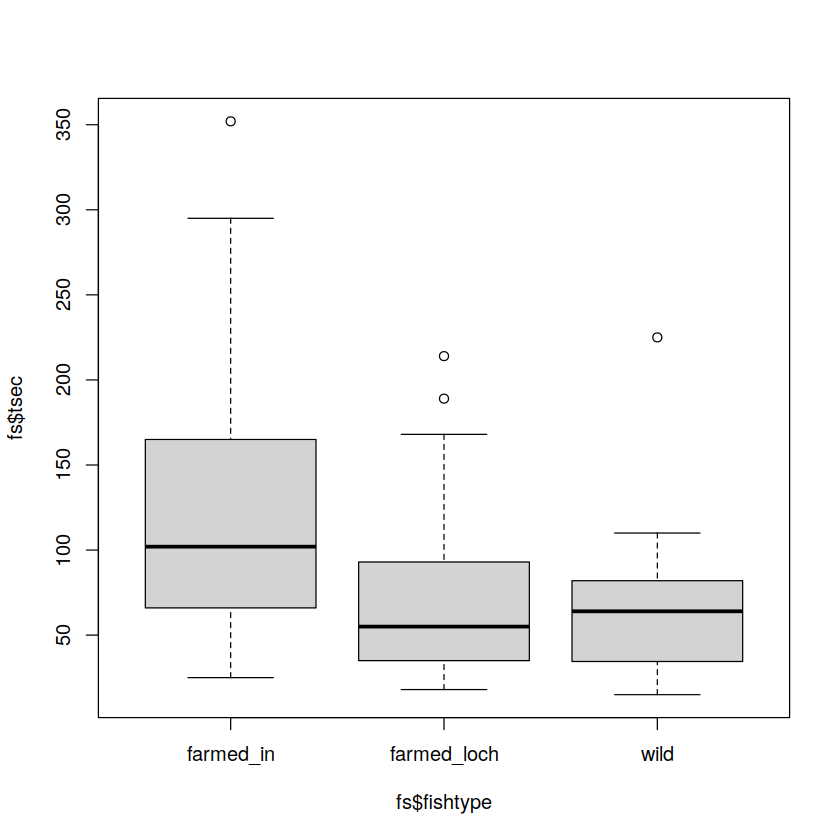

In [8]:
boxplot(fs$tsec ~ fs$fs)
boxplot(fs$tsec ~ fs$fsdir)
boxplot(fs$tsec ~ fs$fishtype)

In [9]:
modeltime <- glm(tsec ~ fishtype + fsdir + fsdir*fishtype,fs,family='Gamma')
summary(modeltime)


Call:
glm(formula = tsec ~ fishtype + fsdir + fsdir * fishtype, family = "Gamma", 
    data = fs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2642  -0.6080  -0.2228   0.2410   1.4717  

Coefficients: (10 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            0.0071575  0.0019725   3.629 0.000633
fishtypefarmed_loch                    0.0101265  0.0051555   1.964 0.054661
fishtypewild                           0.0160309  0.0062948   2.547 0.013758
fsdirhigh_counter                     -0.0131454  0.0065874  -1.996 0.051040
fsdirlow_clock                        -0.0050590  0.0062112  -0.814 0.418938
fsdirlow_counter                      -0.0075374  0.0057262  -1.316 0.193634
fsdirold_clock                         0.0009463  0.0024937   0.379 0.705830
fsdirold_counter                              NA         NA      NA       NA
fishtypefarmed_loch:fsdirhigh_counter

## Absolute flow 10second average as an explanatory variable

For one of the flow conditions it is a little bit different but doesn't really

In [10]:
fs$abs10 <- fs$abs10 + 0.00001 # there are some values equal 0 we cannto model gamm with that so we shift all ever so slightly

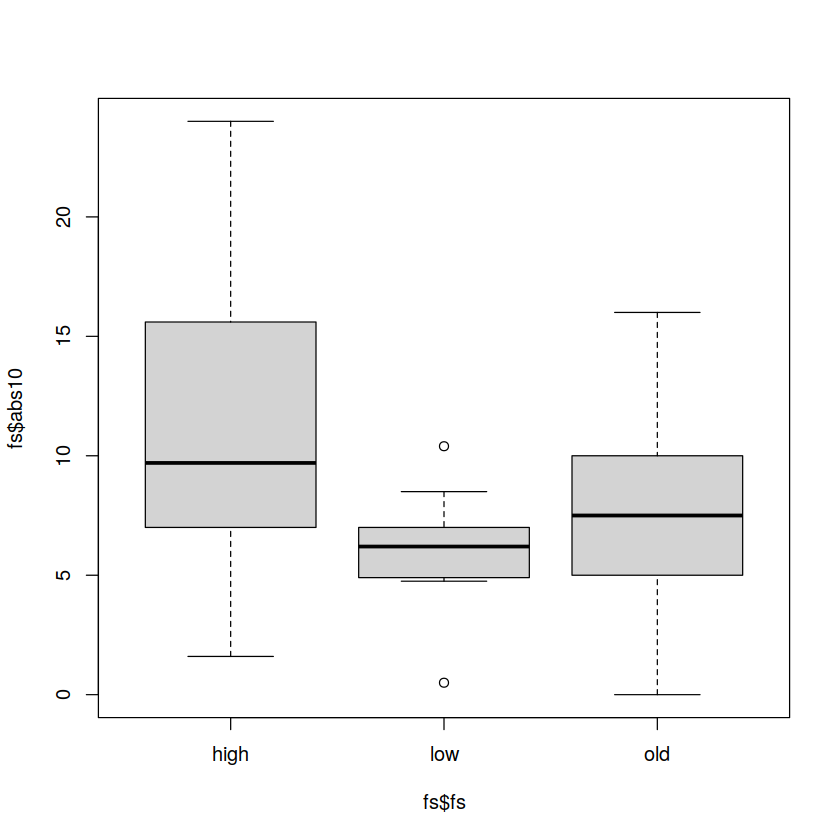

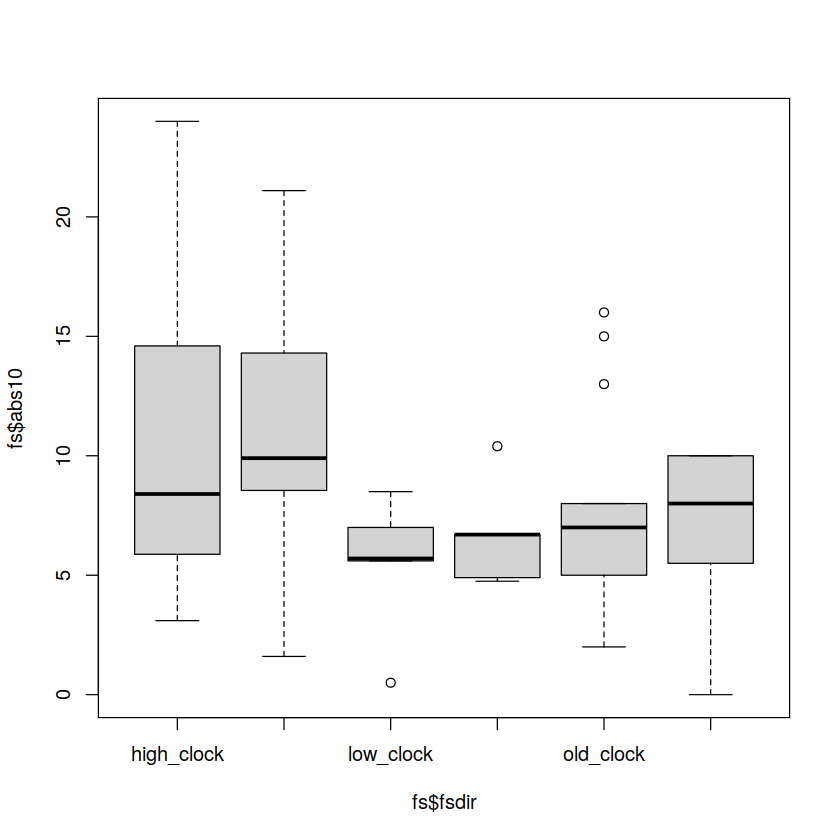


Call:
glm(formula = abs10 ~ fishtype + fsdir + fsdir * fishtype, family = "Gamma", 
    data = fs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.9918  -0.3759  -0.0440   0.3551   0.8726  

Coefficients: (10 not defined because of singularities)
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.142857   0.028847   4.952 7.59e-06 ***
fishtypefarmed_loch                   -0.059375   0.033411  -1.777   0.0812 .  
fishtypewild                          -0.035402   0.035271  -1.004   0.3200    
fsdirhigh_counter                     -0.041104   0.024320  -1.690   0.0968 .  
fsdirlow_clock                         0.099668   0.046893   2.125   0.0381 *  
fsdirlow_counter                       0.065994   0.039492   1.671   0.1005    
fsdirold_clock                        -0.008929   0.034255  -0.261   0.7954    
fsdirold_counter                             NA         NA      NA       NA    
fishtypef

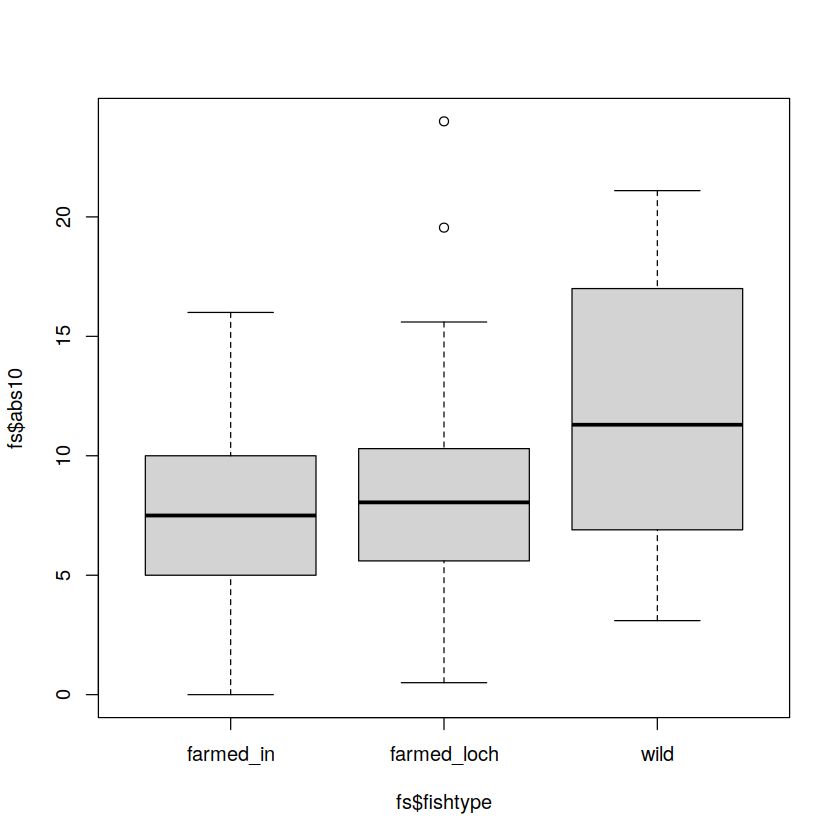

In [11]:
boxplot(fs$abs10 ~ fs$fs)
boxplot(fs$abs10 ~ fs$fsdir)
boxplot(fs$abs10 ~ fs$fishtype)

modelflow <- glm(abs10 ~ fishtype + fsdir + fsdir*fishtype,fs,family='Gamma')
summary(modelflow)

## Flow as a fraction of stable flow when holding as an explanatory variable

no

In [12]:
fs$asfractprev10 <- abs(fs$asfractprev10) + 0.00001

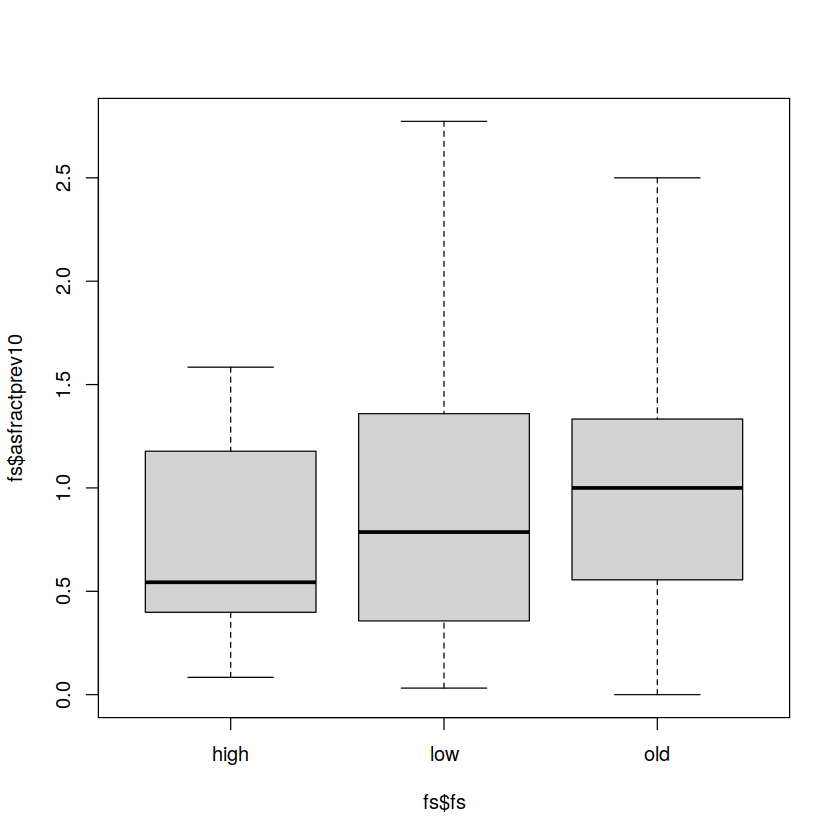

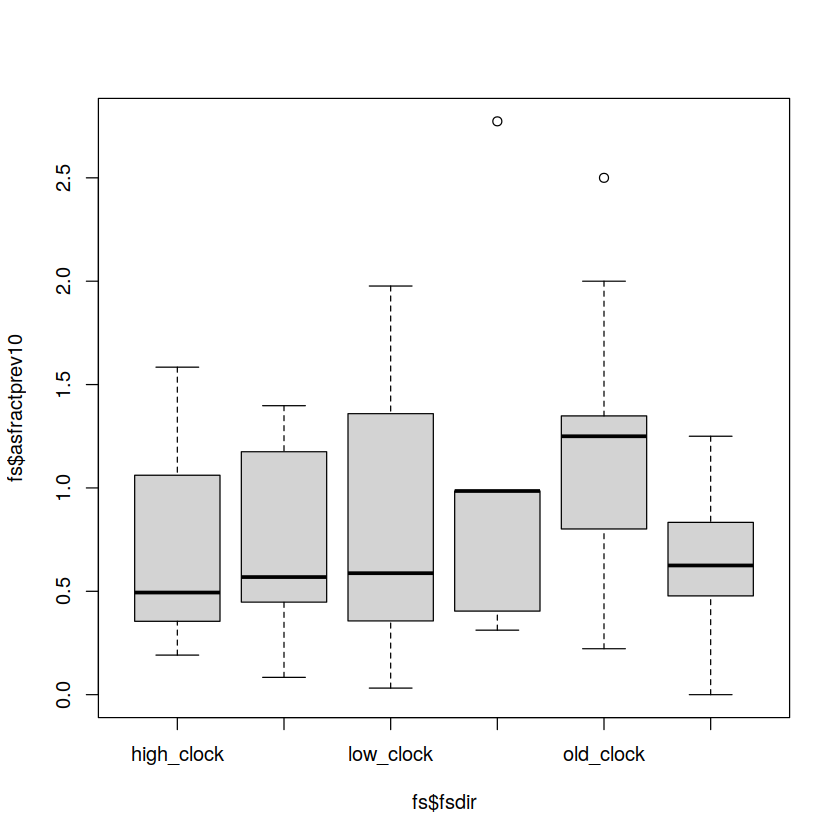


Call:
glm(formula = asfractprev10 ~ fishtype + fsdir + fsdir * fishtype, 
    family = "Gamma", data = fs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4879  -0.5263  -0.1141   0.2693   1.1023  

Coefficients: (10 not defined because of singularities)
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            1.55649    0.39057   3.985 0.000204 ***
fishtypefarmed_loch                   -0.25968    0.50837  -0.511 0.611565    
fishtypewild                           0.03226    0.54001   0.060 0.952590    
fsdirhigh_counter                     -0.49776    0.46262  -1.076 0.286728    
fsdirlow_clock                        -0.13731    0.47372  -0.290 0.773043    
fsdirlow_counter                      -0.38112    0.42404  -0.899 0.372760    
fsdirold_clock                        -0.69471    0.41757  -1.664 0.101969    
fsdirold_counter                            NA         NA      NA       NA    
fishtypefa

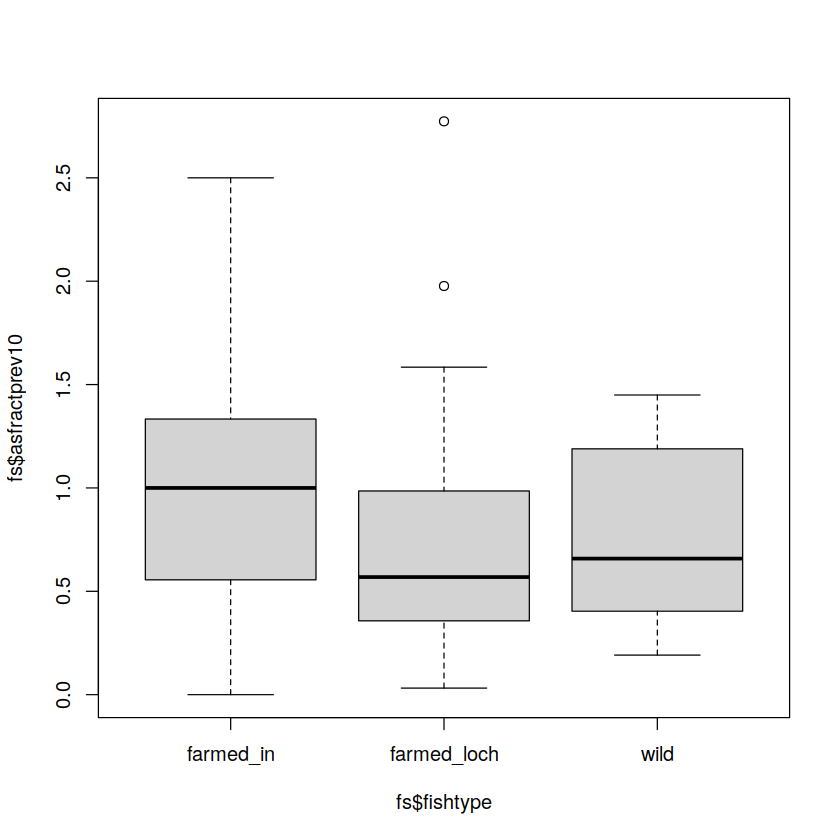

In [13]:
boxplot(fs$asfractprev10 ~ fs$fs)
boxplot(fs$asfractprev10 ~ fs$fsdir)
boxplot(fs$asfractprev10 ~ fs$fishtype)

modelflowasfract <- glm(asfractprev10 ~ fishtype + fsdir + fsdir*fishtype,fs,family='Gamma')
summary(modelflowasfract)